# Emotion Recognition Application With Deep Learning From Face Images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import the libraries
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.preprocessing import image
import keras.utils as image
from keras.callbacks import ModelCheckpoint

* **Dataset** : [KAGGLE- Challenges in Representation Learning: Facial Expression Recognition Challenge](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data)


In [ ]:
# read data
root = ' '
data = pd.read_csv(root + '/data/fer2013.csv')
data.shape

(35887, 3)

In [ ]:
data["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

### Pre-Processing Steps for Training Data

In [ ]:
np.unique(data["Usage"].values.ravel())

print('Number of samples in the training set: %d'%(len(data[data.Usage == "Training"])))

Number of samples in the training set: 28709


In [ ]:
train_data = data [data.Usage == "Training"] #just take the training samples into train_data variable.

In [ ]:
#since the pixel values ​​of the training examples are given side by side in the table, they are taken into the variable as a list by parsing from the spaces.
train_pixels = train_data.pixels.str.split(" ").tolist() 

train_pixels = pd.DataFrame(train_pixels, dtype=int)
train_images = train_pixels.values
train_images = train_images.astype(np.float)

print(train_images)

print(train_images.shape)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: Could not cast to int64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-7-d4a7e1128fc4>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_images = train_images.astype(np.float)


[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 74.  81.  87. ... 188. 187. 187.]
 [222. 227. 203. ... 136. 136. 134.]
 [195. 199. 205. ...   6.  15.  38.]]
(28709, 2304)


In [ ]:
#define a function to display the image as 48x48 pixels.
def show(img):
    show_image = img.reshape(48,48)
    
    plt.axis('off')
    plt.imshow(show_image, cmap='gray')

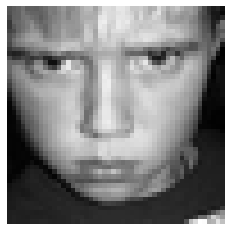

In [ ]:
#from the dataset 
show(train_images[900])

* How many classes are in the training set.

In [ ]:
train_labels_flat = train_data["emotion"].values.ravel()
train_labels_count = np.unique(train_labels_flat).shape[0]
print('Number of different facial expressions: %d'%train_labels_count)

Number of different facial expressions: 7


* With One Hot.Let's see the class that falls on each of the data in the training set, that is, the size of the training process

In [ ]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [ ]:
y_train = dense_to_one_hot(train_labels_flat, train_labels_count)

y_train = y_train.astype(np.uint8)

print(y_train.shape)

(28709, 7)


### Test Data Pre-processing Steps

In [ ]:
np.unique(data["Usage"].values.ravel()) 

print('Number of samples in the test dataset: %d'%(len(data[data.Usage == "PublicTest"])))

Number of samples in the test dataset: 3589


In [ ]:
test_data = data[data.Usage == "PublicTest"] 
test_pixels = test_data.pixels.str.split(" ").tolist() 

test_pixels = pd.DataFrame(test_pixels, dtype=int)
test_images = test_pixels.values
test_images = test_images.astype(np.float)

print(test_images.shape)

<ipython-input-14-e6ba79e735fd>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_images = test_images.astype(np.float)


(3589, 2304)


* An example image from the training set

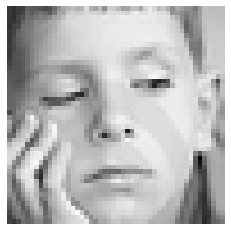

In [ ]:
# a test example
show(test_images[90])

* With One Hot, let's see the class that falls on each of the data in the test set, that is, the size of the training process.

In [ ]:
test_labels_flat = test_data["emotion"].values.ravel()
test_labels_count = np.unique(test_labels_flat).shape[0]

y_test = dense_to_one_hot(test_labels_flat, test_labels_count)

y_test = y_test.astype(np.uint8)

print(y_test.shape)

(3589, 7)


### Sample Images from the Test Set.

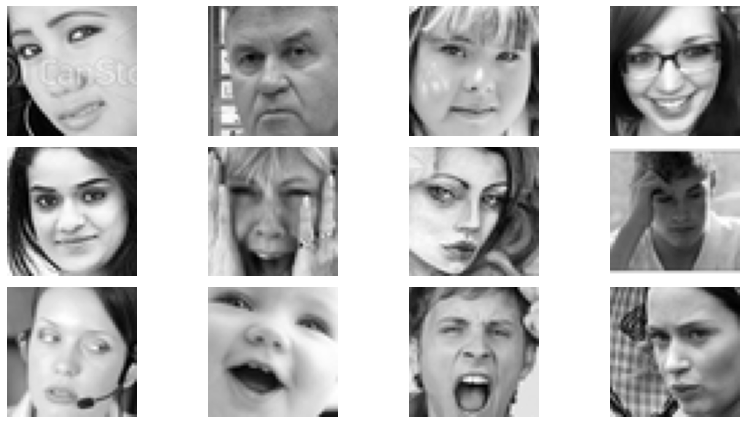

In [ ]:
#test verisetinden örneklerden bir kaçını toplu halde görelim
plt.figure(0, figsize=(12,6))
for i in range(1,13):
  plt.subplot(3, 4, i)
  plt.axis('off')

  image = test_images[i].reshape(48,48)
  plt.imshow(image, cmap='gray')

plt.tight_layout()
plt.show()

## Description of the deep convolutional neural network model

* Write the model

In [ ]:
model = Sequential()

# layer 1
model.add(Conv2D(64, 3, data_format = 'channels_last' , kernel_initializer = 'he_normal', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

## layer 2
model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides = 2))
model.add(Dropout(0.6)) #60% forgetting (neuron deletion-dropout)

### layer 3
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))

#### layer 4
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))


##### layer 5
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.6)) 

### full link layer
model.add(Flatten())
model.add(Dense(128)) # It reduces the flatten vector of 2048 to 128
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))

###  output layer

model.add(Dense(7)) # Classification process (there are 7 emotion classes)
model.add(Activation('softmax'))

model.compile(loss= 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy']) # determination of optimization and achievement calculation metrics

### visualize model summary
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 44, 44, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 44, 44, 64)        0

### Write the number of elements, height and width, number of channels of the training and test sets to the screen.

In [ ]:
x_train = train_images.reshape(-1, 48, 48, 1)
x_test = test_images.reshape(-1, 48, 48, 1)

print('Train', x_train.shape)
print('Test', x_test.shape)

Train (28709, 48, 48, 1)
Test (3589, 48, 48, 1)


### Number of elements and emotion classes of the training and test sets.

In [ ]:
print('Train', y_train.shape)
print('Test', y_test.shape)

Train (28709, 7)
Test (3589, 7)


- The processes of determining the values ​​such as epoch and batchsize that we want the training process to take place and saving the weights as a .h5 file as a result of the training.

In [ ]:
# save the most successful weights
root = ' '
chechpointer = ModelCheckpoint(filepath=root + 'data/face_model.h5', verbose=1, save_best_only=True)

epochs = 15
bactSize = 100

# run model(train)
## To shuffle means to shuffle images.:) 
hist = model.fit(x_train, y_train,
                    epochs = epochs,
                    shuffle = True,
                    batch_size = bactSize,
                    validation_data = (x_test, y_test),
                    callbacks = [chechpointer], verbose=2)

# save model to json
model_json = model.to_json()
with open(root + 'data/face_model.json0', 'w') as json_file:
  json_file.write(model_json)



- Processes of graphically expressing and printing the training and validation results obtained as a result of the training.

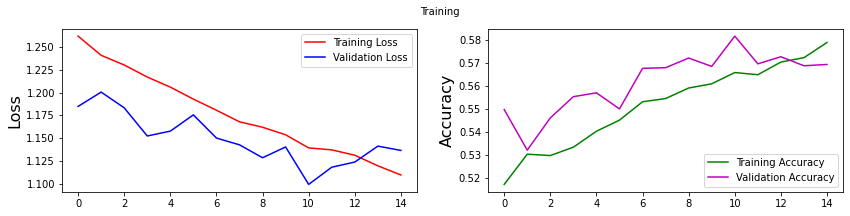

In [ ]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Training', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color ='r', label='Training Loss')
plt.plot(hist.history['val_loss'], color ='b', label='Validation Loss')
plt.legend(loc='upper right') # This is how you choose where to write the information.


plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color ='g', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color ='m', label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()


- Test with **PrivateTest** examples like Kaggle will submit

In [ ]:
test = data[["emotion", "pixels"]][data["Usage"] == "PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im, sep=' '))

test.head()

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


In [ ]:
x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])

In [ ]:
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = np_utils.to_categorical(y_test_private)
x_test_private.shape, y_test_private.shape

((3589, 48, 48, 1), (3589, 7))

In [ ]:
score = model.evaluate(x_test_private, y_test_private, verbose=0)
print("Accuracy status on PrivateTest: ", score)

Accuracy status on PrivateTest:  [1.1217355728149414, 0.5762050747871399]


-  With the training part in the dataset, the model is trained and the test operations are performed with the data reserved for testing.


### Perform tests with different images and visualize the results.

In [ ]:
from keras.models import load_model
from PIL import Image
from keras.preprocessing import image

* It uses the learned weight file calculated by the model saved in the previous tutorial.

In [ ]:
# load best weights
model_best = load_model(root + 'data/face_model.h5')


In [ ]:
#test_image=x_test_private[60] #if you want to try an image from the dataset, you can test it here by assigning a random image number to []!

image_path = root + "/images/AlPacino2.jpg"

test_image_original = image.load_img(image_path) # original color image

test_image = image.load_img(image_path, target_size=(48, 48), grayscale=True)
test_data = image.img_to_array(test_image)

test_data = np.expand_dims(test_data, axis=0)
test_data = np.vstack([test_data])

results = model_best.predict(test_data, batch_size=1)
results


/usr/local/lib/python3.8/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 0s 420ms/step


array([[0.3470748 , 0.00594845, 0.1663868 , 0.31231248, 0.1440605 ,
        0.00962175, 0.01459516]], dtype=float32)

### Steps to Visualize The Results.

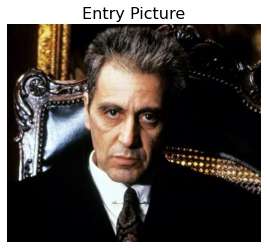

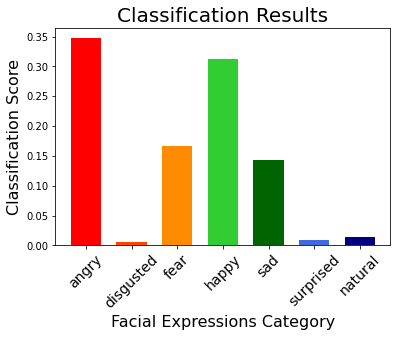

Classification result with the highest rate:  angry


In [ ]:
#classes: 7 emotional states
class_names = ['angry', 'disgusted', 'fear', 'happy', 'sad', 'surprised', 'natural']

ind = 0.1+0.6*np.arange(len(class_names))
width = 0.4  # bar width

color_list = ['red','orangered','darkorange','limegreen','darkgreen','royalblue','navy']

# draw the test picture.

plt.imshow(test_image_original)
plt.title('Entry Picture', fontsize=16)
plt.axis('off')
plt.show()

# color the results

for i in range(len(class_names)):
  plt.bar(ind[i], results[0][i], width, color=color_list[i])

plt.title("Classification Results", fontsize=20)
plt.xlabel("Facial Expressions Category",fontsize=16)
plt.ylabel("Classification Score",fontsize=16)
plt.xticks(ind, class_names, rotation=45, fontsize=14)
plt.show()


print("Classification result with the highest rate: ", class_names[np.argmax(results)])


In [ ]:
import keras.utils as image
image_path = root + "/images/fear.png"

test_image_original = image.load_img(image_path) 

test_image = image.load_img(image_path, target_size=(48, 48), grayscale=True)
test_data = image.img_to_array(test_image)

test_data = np.expand_dims(test_data, axis=0)
test_data = np.vstack([test_data])

results = model_best.predict(test_data, batch_size=1)
results


1/1 [==============================] - 0s 21ms/step


array([[0.08106471, 0.01291807, 0.36094013, 0.09624217, 0.17091882,
        0.16520688, 0.11270919]], dtype=float32)

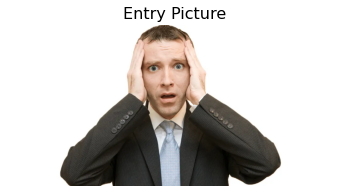

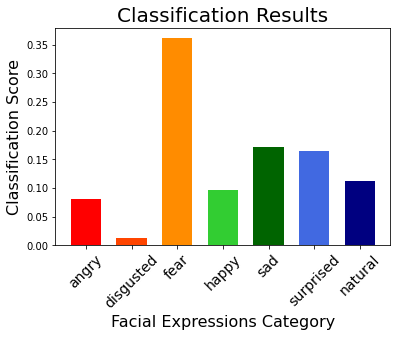

Classification result with the highest rate:  fear


In [ ]:

class_names = ['angry', 'disgusted', 'fear', 'happy', 'sad', 'surprised', 'natural']

ind = 0.1+0.6*np.arange(len(class_names))
width = 0.4  

color_list = ['red','orangered','darkorange','limegreen','darkgreen','royalblue','navy']



plt.imshow(test_image_original)
plt.title('Entry Picture', fontsize=16)
plt.axis('off')
plt.show()



for i in range(len(class_names)):
  plt.bar(ind[i], results[0][i], width, color=color_list[i])

plt.title("Classification Results", fontsize=20)
plt.xlabel("Facial Expressions Category",fontsize=16)
plt.ylabel("Classification Score",fontsize=16)
plt.xticks(ind, class_names, rotation=45, fontsize=14)
plt.show()


print("Classification result with the highest rate: ", class_names[np.argmax(results)])